Few shot learning algorithm

Following this guide: https://medium.com/analytics-vidhya/creating-your-own-intent-classifier-b86e000a4926

In [50]:
import numpy as np
import json

In [51]:
# Load in the data file
with open('./question-data.json') as data_file:
    data = json.loads(data_file.read())

# Prepare the data
train_data = []
for index in data:
    train_data += [[data[index][x], index] for x in range(len(data[index]))]
train_data = np.array(train_data)
train_data = train_data.T

text = train_data[0] # All text 
labels = train_data[1] # All labels for text

In [52]:
# Split data into training and testing sections
from sklearn.model_selection import train_test_split

train_txt, test_txt, train_label, test_labels = train_test_split(text, labels, test_size = 0.3)

Data pre-processing

In [53]:
# Tokenizing the text
import tensorflow as tf
max_num_words = 40000
classes = np.unique(labels)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index

In [54]:
# Padding the tokens so that they are all the same length
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [55]:
# One hot encoding for the labels
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [56]:
# Get word embeddings
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [57]:
# Use word embeddings to create a matrix
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/Users/danielstefanescu/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [58]:
# Model preperation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [59]:
# Model training

history = model.fit(train_sequences, train_label, epochs = 30,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Epoch 1/30


2022-10-13 23:16:01.072704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1.1491 - acc: 0.1538

2022-10-13 23:16:03.611085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 1.1491 - acc: 0.1538 - val_loss: 1.1507 - val_acc: 0.1667
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 1.0339 - acc: 0.5385 - val_loss: 1.1826 - val_acc: 0.1667
Epoch 3/30
1/1 [==============================] - 1s 982ms/step - loss: 0.9747 - acc: 0.4615 - val_loss: 1.3244 - val_acc: 0.1667
Epoch 4/30
1/1 [==============================] - 1s 977ms/step - loss: 0.8893 - acc: 0.6154 - val_loss: 1.4396 - val_acc: 0.1667
Epoch 5/30
1/1 [==============================] - 1s 963ms/step - loss: 0.8912 - acc: 0.7692 - val_loss: 1.4822 - val_acc: 0.1667
Epoch 6/30
1/1 [==============================] - 1s 959ms/step - loss: 0.8693 - acc: 0.5385 - val_loss: 1.5281 - val_acc: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 1s 944ms/step - loss: 0.6472 - acc: 0.8462 - val_loss: 1.5930 - val_acc: 0.0000e+00
Epoch 8/30
1/1 [==============================] - 1s 966ms/step - loss: 0.5732 - acc: 0.6923 - val_

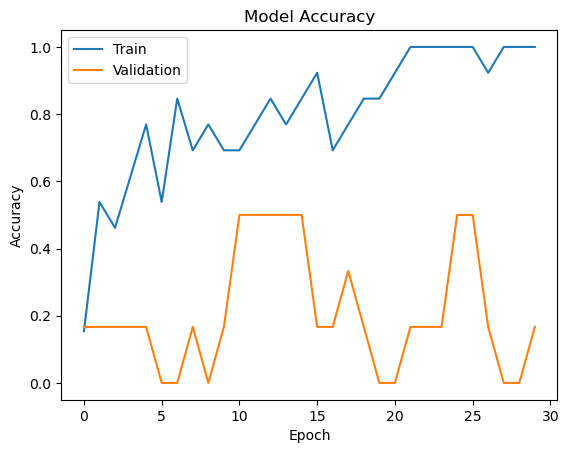

In [60]:
# Plotting the results:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()